<a href="https://colab.research.google.com/github/MateiGrama/personalportfolio/blob/master/Copy_of_coursework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [0]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from functools import reduce

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [0]:
# Load data (provided)
trns = transform=transforms.Compose([transforms.Grayscale(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True,transform=trns)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False,transform=trns)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)


### 1.1 Display the dimension of the training and test sets. (5 marks)

In [0]:
print("Training set size: {}\nTest set size: \t   {}\n".format(len(train_set.data), len(test_set.data)))


Training set size: 60000
Test set size: 	   10000



### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


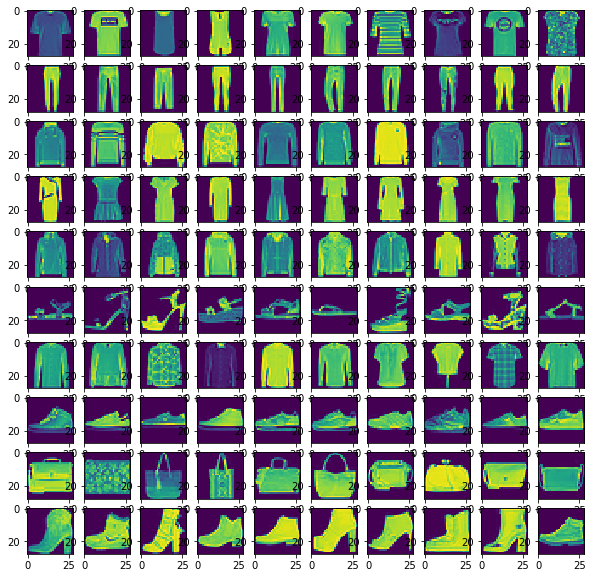

In [0]:
fig = plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(columns * rows):
    img = train_image[list(np.where(train_label == i // rows))][i % columns - 1]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)

### 1.3 Display the number of training samples for each class. (5 marks)

In [0]:
for i in range(len(class_name)):
  print("No. of samples of class {} is {}\n".format(class_name[i], np.count_nonzero(train_label == i)))


No. of samples of class T-shirt/top is 6000

No. of samples of class Trouser is 6000

No. of samples of class Pullover is 6000

No. of samples of class Dress is 6000

No. of samples of class Coat is 6000

No. of samples of class Sandal is 6000

No. of samples of class Shirt is 6000

No. of samples of class Sneaker is 6000

No. of samples of class Bag is 6000

No. of samples of class Ankle boot is 6000



### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

Yes, the data set is balanced as there are an equal number of samples corresponding to each of the classes.

Using an unbalenced dataset while training can result in low general performace of the model, as the metrics can't reflect the training results well enough, e.g the model can become very good at recongnizing the dominant class but not the others.

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](https://github.com/ImperialCollegeLondon/Computer_Vision_2020/blob/master/coursework_2/lenet.png?raw=1)

In [0]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [0]:
num_epochs = 3
batch_size = 100
learning_rate = 0.01

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [0]:
for i in range(num_epochs):
    cum_loss = 0
    start = time.time()

    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_images)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
    end = time.time()
     
    print(f"Training loss: {cum_loss/len(train_loader)}")
    #print(f"Training duration at epoch {epoch + 1}: {str(end - start)}\t")


Training loss: 1.219068562189738
Training loss: 0.6219546645879745
Training loss: 0.5394836876293023



### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [0]:
torch_test_images  = torch.from_numpy(test_image).float()
torch_test_labels  = torch.from_numpy(test_label)

total = 0
num_correct = 0
with torch.no_grad():
    start = time.time()

    for test_images, test_labels in test_loader:
        
        output = torch.exp(model(test_images))        
        predictions = torch.argmax(output, 1)
        total += test_labels.size(0)
        num_correct += (predictions == test_labels).sum().item()
    
    end = time.time()


print ("Testing duration: " + str(end - start))


Testing duration: 1.658459186553955


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [0]:
print(f'Accuracy of the model on the test images: {num_correct * 100 / total}% ')

Accuracy of the model on the test images: 80.47% 


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

['.ipynb_checkpoints', '0', '7', '8']
tensor([1])
tensor([2])
tensor([3])


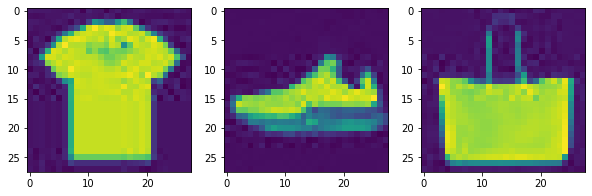

In [0]:
own_set = torchvision.datasets.ImageFolder(root='./images', transform=trns)
own_loader = torch.utils.data.DataLoader(own_set)

print(own_set.classes)
for x,y in own_loader: print (y)

fig = plt.figure(figsize=(10, 10))
for i, (img, _) in enumerate(own_loader):
    fig.add_subplot(1, 3, i + 1)
    plt.imshow(torch.squeeze(torch.squeeze(img, 0), 0))

### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [0]:
total = 0
num_correct = 0
with torch.no_grad():
    for own_images, own_labels in own_loader:
        output = torch.exp(model(own_images))        
        predictions = torch.argmax(output, 1)
        print("true {} prediction {}".format(own_labels, predictions))
        total += own_labels.size(0)
        num_correct += (predictions == own_labels).sum().item()

print(f'Accuracy of the model on the test images: {num_correct * 100 / total}% ')

ValueError: ignored

### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?